In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
from matmul import linear_estimates_summa, logit_estimates_summa, attend_estimates_summa, fused_logit_softmax_dpr_attend_estimates
from norm import layer_norm_estimates
from pointwise import softmax_estimates, dropout_estimates, nonlinear_act_estimates
from time_projections import get_time_flops, get_time_mem, get_time_comm, get_topology, get_total_time

In [3]:
def compute_timings_and_stats(summary, system):
    ''' timings, any other df stats '''

    # which layers use tensor cores
    tensor_core_layers = ['fc1', 'fc2', 'qkv_proj', 'v_proj', 'logits', 'attend']
   
    # time for forward
    summary['t_comp_fwd'] = summary.apply(lambda x: get_time_flops(x["flops_fwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_fwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_fwd"], system=system), axis=1)
    # time for backward
    summary['t_comp_bwd'] = summary.apply(lambda x: get_time_flops(x["flops_bwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_bwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_bwd"], system=system), axis=1)
    
    # times
    summary['intensity'] = summary['t_comp_fwd'] / summary['t_mem_fwd']
    summary['t_fwd'] = summary.apply(lambda x: max(x['t_comp_fwd'], x['t_mem_fwd']), axis=1)
    summary['t_bwd'] = summary.apply(lambda x: max(x['t_comp_bwd'], x['t_mem_bwd']), axis=1)
    
    # time for communication
    use_empirical = False
    summary['comm_fwd_topology'] = summary.apply(lambda x: get_topology(x["comm_fwd_size"], x["comm_fwd_topology"], system=system), axis=1)
    summary['comm_bwd_topology'] = summary.apply(lambda x: get_topology(x["comm_bwd_size"], x["comm_bwd_topology"], system=system), axis=1)
    summary['t_comm_fwd'] = summary.apply(lambda x: get_time_comm(x["comm_fwd"],
                                                                  n_gpuss=x["comm_fwd_size"],
                                                                  comm_types=x["comm_fwd_type"], 
                                                                  topologys=x["comm_fwd_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    summary['t_comm_bwd'] = summary.apply(lambda x: get_time_comm(x["comm_bwd"],
                                                                  n_gpuss=x["comm_bwd_size"],
                                                                  comm_types=x["comm_bwd_type"], 
                                                                  topologys=x["comm_bwd_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    
    # total time
    summary['t_total_fwd'] = summary.apply(lambda x: get_total_time(x['t_fwd'], x['t_comm_fwd'], use_max=False), axis=1)
    summary['t_total_bwd'] = summary.apply(lambda x: get_total_time(x['t_bwd'], x['t_comm_bwd'], use_max=False), axis=1)
    
    # fraction
    summary['frac_t_comm_fwd'] = summary['t_comm_fwd'] / summary['t_total_fwd']
    summary['frac_t_comm_bwd'] = summary['t_comm_bwd'] / summary['t_total_bwd']

    return summary

In [4]:
#### nn modules ###
def MLP_estimates(b, l, e, f, depth, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12,
                  parallelism={'m1': 1, 'm2': 1}, topology={'t1': 'nvlink', 't2': 'ib'}, system={}):
    """
    MLP layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim
                f: hidden dim
                element_size: in MB
                mask_element_size: in MB (for dropout)
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        forward pass: 
             X = XW + b
             (b,l,f) = (b,l,e) * (e,f) + (1,f)
             X = nonlinear(X)
             (b,l,f) = (b,l,f)
             X = dropout(X)
             (b,l,f) = (b,l,f) * (b,l,f) [random mask]
             X = linear(X)
             (b,l,e) = (b,l,f) * (f,e) + (1,e)
             X = dropout(X)
             (b,l,e) = (b,l,e) * (b,l,e) [random mask]
            
        backward pass:
             chain rule
             
    parallelism:
            X = XW + b
            (b,l/m2,f/m1) = (b,l/m2,e/m1) * (e/m2,f/m1) + (1,f/m1)
            X = nonlinear(X)
            (b,l/m2,f/m1) = (b,l/m2,f/m1)
            X = dropout(X)
            (b,l/m2,f/m1) = (b,l/m2,f/m1) * (b,l/m2,f/m1) [random mask]
            X = linear(X)
            (b,l/m2,e/m1) = (b,l/m2,f/m1) * (f/m2,e/m1) + (1,e/m1)
            X = dropout(X)
            (b,l/m2,e/m1) = (b,l/m2,e/m1) * (b,l/m2,e/m1) [random mask]
            
    comments: 
    """
    
    summary = []
    
    m1 = parallelism['m1']
    m2 = parallelism['m2'] 
    
    t1 = topology['t1']
    t2 = topology['t2']
        
    ######################################################################################################################################################
    ######################################################################################################################################################
    stats = linear_estimates_summa(b, l, e, f, element_size=element_size, has_bias=True, flops_units=flops_units, 
                                   parallelism={'dim1': m1, 'dim2': m2}, topology={'dim1': t1, 'dim2': t2})
    stats["layer"] = "fc1"   
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = nonlinear_act_estimates(b, l // m2, f // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "act"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m2, f // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dpr1"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates_summa(b, l, f, e, element_size=element_size, has_bias=True, flops_units=flops_units, 
                                   parallelism={'dim1': m1, 'dim2': m2}, topology={'dim1': t1, 'dim2': t2})
    stats["layer"] = "fc2"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m2, e // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dpr2"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)
    
    return summary
        

In [5]:
def self_attention_estimates(b, l, e, h, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12, flash_attention=True, 
                             parallelism={'m1': 1, 'm2': 1}, topology={'t1': 'nvlink', 't2': 'ib'}, system={}):
    """
    dropout layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim/hidden dim
                h: number of attention heads
                element_size: in MB
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        define: q = e/h
        forward pass: 
             X = norm(X)
             Q = XW, K = XW, V = XW
             (b,l,h,q,3) = (b,l,e) * (e,3hq)
             A = QK'/sqrt(q)
             (b,h,l,l) = (b,h,l,q) * (b,h,q,l)
             A = softmax(A)
             (b,h,l,l) = (b,h,l,l)
             A = dpr(A)
             Y = AV
             (b,h,l,q) = (b,h,l,l) * (b,h,l,q)
             Y = VW
             (b,l,e) = (b,l,hq) * (hq,e)
             Y = dpr(Y)
             (b,l,e) = (b,l,e)
             Y = norm(Y)
             (b,l,e) = (b,l,e)
             
        backward pass:
             chain rule
             
        parallelism: 
             X = norm(X)
             (b,l/m2,e/m1) = (b,l/m2,e/m1)
             Q = XW, K = XW, V = XW
             (b,h,l/m2,q/m1,3) = (b,l/m2,e/m1) * (e/m2,3hq/m1)
             A = QK'/sqrt(q)
             (b,h,l/m2,l/m1) = (b,h,l/m2,q/m1) * (b,h,q/m2,l/m1)
             A = softmax(A)
             (b,h,l/m2,l/m1) = (b,h,l/m2,l/m1)
             A = dpr(A)
             (b,h,l/m2,l/m1) = (b,h,l/m2,l/m1)
             Y = AV
             (b,h,l/m2,q/m1) = (b,h,l/m2,l/m1) * (b,h,l/m2,q/m1)
             Y = VW
             (b,l/m2,e/m1) = (b,l/m2,hq/m1) * (hq/m2,e/m1)
             Y = dpr(Y)
             (b,l/m2,e/m1) = (b,l/m2,e/m1)
             Y = norm(Y)
             (b,l/m2,e/m1) = (b,l/m2,e/m1)
            
    
    comments: 
    """
    summary = []
    
    q = e // h
    
    m1 = parallelism['m1']
    m2 = parallelism['m2'] 
    
    t1 = topology['t1']
    t2 = topology['t2']
    
    m1_parallel = (m1 > 1)
    m2_parallel = (m2 > 1)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    stats = layer_norm_estimates(b, l // m2, e // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_1"
    # sync/comm layers
    stats["comm_fwd"] =  m1_parallel * (2 * b * l // m2) * element_size
    stats["comm_fwd_type"] = "allreduce"
    stats["comm_fwd_size"] = m1
    stats["comm_fwd_topology"] = t1
    stats["comm_bwd"] =  m1_parallel * (2 * e // m1 + 2 * b * l // m2) * element_size
    stats["comm_bwd_type"] = "allreduce"
    stats["comm_bwd_size"] = m1
    stats["comm_bwd_topology"] = t1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    stats = linear_estimates_summa(b, l, e, (3 * e), element_size=element_size, has_bias=False, flops_units=flops_units, 
                                   parallelism={'dim1': m1, 'dim2': m2}, topology={'dim1': t1, 'dim2': t2})
    stats["layer"] = "qkv_proj"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = logit_estimates_summa(b, l, q, h, element_size=element_size, flops_units=flops_units, 
                                  parallelism={'dim1': m1, 'dim2': m2}, topology={'dim1': t1, 'dim2': t2})
    stats["layer"] = "logits"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################

    stats = softmax_estimates(b, l // m2, l // m1, h, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "softmax"
    # sync/comm layers
    # sync/comm layers
    stats["comm_fwd"] =  m1_parallel * (b * h * l // m2) * element_size
    stats["comm_fwd_type"] = "allreduce"
    stats["comm_fwd_size"] = m1
    stats["comm_fwd_topology"] = t1
    stats["comm_bwd"] =  m1_parallel * (b * h * l // m2) * element_size
    stats["comm_bwd_type"] = "allreduce"
    stats["comm_bwd_size"] = m1
    stats["comm_bwd_topology"] = t1
    summary.append(stats)

    ######################################################################################################################################################
    ######################################################################################################################################################

    stats = dropout_estimates(b, l // m2, (l*h) // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dropout_softmax"
    summary.append(stats)

    ######################################################################################################################################################
    ######################################################################################################################################################

    stats = attend_estimates_summa(b, l, q, h, element_size=element_size, flops_units=flops_units, 
                                   parallelism={'dim1': m1, 'dim2': m2}, topology={'dim1': t1, 'dim2': t2})
    stats["layer"] = "attend"
    summary.append(stats)    
    
    ######################################################################################################################################################
    ######################################################################################################################################################
   
    stats = linear_estimates_summa(b, l, (h * q), e, element_size=element_size, has_bias=True, flops_units=flops_units, 
                                   parallelism={'dim1': m1, 'dim2': m2}, topology={'dim1': t1, 'dim2': t2})
    stats["layer"] = "v_proj"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m2, e // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dropout"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = layer_norm_estimates(b, l // m2, e // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_2"
    # sync/comm layers
    stats["comm_fwd"] =  m1_parallel * (2 * b * l // m2) * element_size
    stats["comm_fwd_type"] = "allreduce"
    stats["comm_fwd_size"] = m1
    stats["comm_fwd_topology"] = t1
    stats["comm_bwd"] =  m1_parallel * (2 * e // m1 + 2 * b * l // m2) * element_size
    stats["comm_bwd_type"] = "allreduce"
    stats["comm_bwd_size"] = m1
    stats["comm_bwd_topology"] = t1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)

    
    return summary

In [15]:
### model
pd.options.display.max_columns = None
pd.options.display.max_rows = None
b = 1
patch = 16
ih = 720
iw = 1440

gpt2 = {'l': 1024, 'e': 1600, 'h': 12, 'depth': 48}
gpt3 = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96 // 8}
vit_era5 = {'l': 16200, 'e': 2048, 'h': 16, 'depth': 24}

model = gpt2
l = model['l']
e = model['e']
f = 4 * e
h = model['h']
depth = model['depth']
fp32_sz = 4E-9
fp16_sz = 2E-9
int_sz = 1E-9
flops_units = 1E-12 # teraflops

print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

### model parallelism
parallelism = {'m1': 4,
               'm2': 4}
topology = {'t1': 'ib',
            't2': 'nvlink'}

### system configs
system = {'matrix_flops_fp16': 312,
          'vector_flops_fp32': 19.5,
          'vector_flops_fp16': 78,
          'hbm_bandwidth': 1555,
          'nvlink_bandwidth': 300,
          'ib_bandwidth': 100,
          'nvlink_size': 4}
print("parallelization: m1 = {}, m2 = {}".format(parallelism['m1'], parallelism['m2']))

# MLP
df_mlp = MLP_estimates(b, l, e, f, depth, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                       parallelism=parallelism, topology=topology, system=system)
cols = df_mlp.columns.tolist()
cols.remove('layer')
cols = ['layer'] + cols

# self attention
df_sa = self_attention_estimates(b, l, e, h, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                                 flash_attention=True, parallelism=parallelism, topology=topology, system=system)

# sum these columns (mem in buffer: activation buffers, weights, weights_grads, total flops, timings)
layer_track_cols = ['activation_buffer', 'weights_mem', 
                    'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                    't_total_fwd', 't_total_bwd', 't_comm_fwd', 't_comm_bwd']

print('\n************** MLP layer estimates **************\n')
display(df_mlp[cols])
display(df_mlp[layer_track_cols].sum() * depth)
t_f = df_mlp['t_total_fwd'].sum()
t_c = df_mlp['t_comm_fwd'].sum()
print('time spend in comms = {}'.format(t_c / t_f))

print('\n************** SA layer estimates **************\n')
display(df_sa[cols])
display(df_sa[layer_track_cols].sum() * depth)
t_f = df_sa['t_total_fwd'].sum()
t_c = df_sa['t_comm_fwd'].sum()
print('time spend in comms = {}'.format(t_c / t_f))

print('\n************** Training estimates **************\n')
t_itr = (df_mlp['t_total_fwd'].sum() + df_mlp['t_total_bwd'].sum() + df_sa['t_total_fwd'].sum() + df_sa['t_total_bwd'].sum()) * depth
print('time for 1 itr = {}'.format(t_itr))

f1 = 3 # 1 fp16 wt, 1 fp32 copy
f2 = 5 # 1 pfp16 grad, 2 fp32 means and variances
mem = (df_mlp['weights_mem'].sum() * f1 + df_mlp['weights_grad_mem'].sum() * f2 + df_mlp['activation_buffer'].sum() +
       df_sa['weights_mem'].sum() * f1 + df_sa['weights_grad_mem'].sum() * f2 + df_sa['activation_buffer'].sum()) * depth
print('mem consumed = {}'.format(mem))

model: batch size = 1, seq length = 1024, embed = 1600, attention heads = 12, depth = 48
parallelization: m1 = 4, m2 = 4

************** MLP layer estimates **************



,layer,flops_fwd,activation_buffer,weights_mem,total_mem_fwd,flops_bwd,weights_grad_mem,total_mem_bwd,comm_fwd,comm_fwd_type,comm_fwd_size,comm_fwd_topology,comm_bwd,comm_bwd_type,comm_bwd_size,comm_bwd_topology,t_comp_fwd,t_mem_fwd,t_comp_bwd,t_mem_bwd,intensity,t_fwd,t_bwd,t_comm_fwd,t_comm_bwd,t_total_fwd,t_total_bwd,frac_t_comm_fwd,frac_t_comm_bwd
0,fc1,1.311130e-03,0.000205,0.001283,0.009216,2.618880e-03,0.001283,0.019254,"[0.0008192000000000001, 0.00512]","[broadcast, broadcast]","[4, 4]","[ib, nvlink]","[0.00512, 0.0008192000000000001, 0.00081920000...","[broadcast, reduce, broadcast, reduce, allreduce]","[4, 4, 4, 4, 4]","[nvlink, ib, ib, nvlink, nvlink]",0.004202,0.005927,0.008394,0.012382,0.709053,0.005927,0.012382,0.025259,0.050528,0.031185,0.062910,0.809953,0.803176
1,act,4.096000e-07,0.000819,0.000000,0.001638,4.096000e-07,0.000000,0.002458,NaN,NaN,NaN,None,NaN,NaN,NaN,None,0.000005,0.001054,0.000005,0.001580,0.004984,0.001054,0.001580,0.000000,0.000000,0.001054,0.001580,0.000000,0.000000
2,dpr1,4.096000e-07,0.000410,0.000000,0.002048,4.096000e-07,0.000000,0.002048,NaN,NaN,NaN,None,NaN,NaN,NaN,None,0.000005,0.001317,0.000005,0.001317,0.003987,0.001317,0.001317,0.000000,0.000000,0.001317,0.001317,0.000000,0.000000
3,fc2,1.310822e-03,0.000819,0.001281,0.009216,2.617344e-03,0.001281,0.018638,"[0.0032768000000000003, 0.00512]","[broadcast, broadcast]","[4, 4]","[ib, nvlink]","[0.00512, 0.0032768000000000003, 0.00327680000...","[broadcast, reduce, broadcast, reduce, allreduce]","[4, 4, 4, 4, 4]","[nvlink, ib, ib, nvlink, nvlink]",0.004201,0.005927,0.008389,0.011986,0.708887,0.005927,0.011986,0.049835,0.099672,0.055761,0.111658,0.893713,0.892658
4,dpr2,1.024000e-07,0.000102,0.000000,0.000512,1.024000e-07,0.000000,0.000512,NaN,NaN,NaN,None,NaN,NaN,NaN,None,0.000001,0.000329,0.000001,0.000329,0.003987,0.000329,0.000329,0.000000,0.000000,0.000329,0.000329,0.000000,0.000000


activation_buffer    0.113050
weights_mem          0.123072
weights_grad_mem     0.123072
flops_fwd            0.125898
flops_bwd            0.251383
t_total_fwd          4.303039
t_total_bwd          8.534141
t_comm_fwd           3.604480
t_comm_bwd           7.209600
dtype: float64

time spend in comms = 0.8376591576885406

************** SA layer estimates **************



,layer,flops_fwd,activation_buffer,weights_mem,total_mem_fwd,flops_bwd,weights_grad_mem,total_mem_bwd,comm_fwd,comm_fwd_type,comm_fwd_size,comm_fwd_topology,comm_bwd,comm_bwd_type,comm_bwd_size,comm_bwd_topology,t_comp_fwd,t_mem_fwd,t_comp_bwd,t_mem_bwd,intensity,t_fwd,t_bwd,t_comm_fwd,t_comm_bwd,t_total_fwd,t_total_bwd,frac_t_comm_fwd,frac_t_comm_bwd
0,layer_norm_1,9.216000e-07,0.000205,0.000002,0.000412,1.227776e-06,0.000002,0.001026,0.000001,allreduce,4,ib,0.000003,allreduce,4,ib,0.000012,0.000265,0.000016,0.000660,0.044570,0.000265,0.000660,0.000010,0.000026,0.000275,0.000686,0.037191,0.038262
1,qkv_proj,9.830400e-04,0.000205,0.000960,0.007117,1.963750e-03,0.000960,0.014234,"[0.0008192000000000001, 0.00384]","[broadcast, broadcast]","[4, 4]","[ib, nvlink]","[0.00384, 0.0008192000000000001, 0.00081920000...","[broadcast, reduce, broadcast, reduce]","[4, 4, 4, 4]","[nvlink, ib, ib, nvlink]",0.003151,0.004577,0.006294,0.009153,0.688434,0.004577,0.009153,0.020992,0.041984,0.025569,0.051137,0.821003,0.821003
2,logits,2.044723e-04,0.000406,0.000000,0.007913,4.150333e-04,0.000000,0.015827,"[0.000811008, 0.006291456000000001]","[broadcast, reduce]","[4, 4]","[nvlink, ib]","[0.012582912000000002, 0.001622016]","[broadcast, broadcast]","[4, 4]","[ib, nvlink]",0.000655,0.005089,0.001330,0.010178,0.128778,0.005089,0.010178,0.065618,0.131236,0.070707,0.141414,0.928026,0.928026
3,softmax,2.356224e-06,0.001573,0.000000,0.003146,3.142656e-06,0.000000,0.004719,0.000006,allreduce,4,ib,0.000006,allreduce,4,ib,0.000030,0.002023,0.000040,0.003034,0.014932,0.002023,0.003034,0.000061,0.000061,0.002084,0.003096,0.029476,0.019846
4,dropout_softmax,7.864320e-07,0.000786,0.000000,0.003932,7.864320e-07,0.000000,0.003932,NaN,NaN,NaN,None,NaN,NaN,NaN,None,0.000010,0.002529,0.000010,0.002529,0.003987,0.002529,0.002529,0.000000,0.000000,0.002529,0.002529,0.000000,0.000000
5,attend,2.076180e-04,0.001776,0.000000,0.007913,4.116849e-04,0.000000,0.015827,"[0.006291456000000001, 0.000811008]","[broadcast, broadcast]","[4, 4]","[ib, nvlink]","[0.000811008, 0.006291456000000001, 0.00629145...","[broadcast, reduce, broadcast, reduce]","[4, 4, 4, 4]","[nvlink, ib, ib, nvlink]",0.000665,0.005089,0.001320,0.010178,0.130760,0.005089,0.010178,0.065618,0.131236,0.070707,0.141414,0.928026,0.928026
6,v_proj,3.269632e-04,0.000204,0.000320,0.002913,6.527770e-04,0.000320,0.006032,"[0.000817152, 0.0012768]","[broadcast, broadcast]","[4, 4]","[ib, nvlink]","[0.0012768, 0.000817152, 0.000817152, 0.001276...","[broadcast, reduce, broadcast, reduce, allreduce]","[4, 4, 4, 4, 4]","[nvlink, ib, ib, nvlink, nvlink]",0.001048,0.001873,0.002092,0.003879,0.559386,0.001873,0.003879,0.012428,0.024858,0.014301,0.028737,0.869001,0.865015
7,dropout,1.024000e-07,0.000102,0.000000,0.000512,1.024000e-07,0.000000,0.000512,NaN,NaN,NaN,None,NaN,NaN,NaN,None,0.000001,0.000329,0.000001,0.000329,0.003987,0.000329,0.000329,0.000000,0.000000,0.000329,0.000329,0.000000,0.000000
8,layer_norm_2,9.216000e-07,0.000205,0.000002,0.000412,1.227776e-06,0.000002,0.001026,0.000001,allreduce,4,ib,0.000003,allreduce,4,ib,0.000012,0.000265,0.000016,0.000660,0.044570,0.000265,0.000660,0.000010,0.000026,0.000275,0.000686,0.037191,0.038262


activation_buffer     0.262152
weights_mem           0.061594
weights_grad_mem      0.061594
flops_fwd             0.082905
flops_bwd             0.165587
t_total_fwd           8.965280
t_total_bwd          17.761321
t_comm_fwd            7.907389
t_comm_bwd           15.812511
dtype: float64

time spend in comms = 0.8820014353618574

************** Training estimates **************

time for 1 itr = 39.56378057672026
mem consumed = 1.8525265920000002


In [7]:
def set_gpus(n, nvs, parallelism, topology):
    factors_of_n = [[i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0]
    if n <= nvs:
        # set all gpus within nvlink
        best_factor = factors_of_n[-1]
        parallelism['m1'] = best_factor[0]
        parallelism['m1'] = best_factor[1]
        topology['t1'] = 'nvlink'
        topology['t2'] = 'nvlink'
    else:
        best_factor = factors_of_n[-1]
        parallelism['m1'] = best_factor[0]
        parallelism['m1'] = best_factor[1]
        topology['t1'] = 'ib'
        topology['t2'] = 'ib'
    return parallelism, topology
        
        

def plot(n_gpus, parallelism, topology, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_frac_mlp = []
    t_frac_sa = []

    t_mlp_c = []
    t_sa_c = []

    t_mlp_comm = []
    t_sa_comm = []
    
    t_itr = []

    for n in n_gpus:
        parallelism, topology = set_gpus(n, system['nvlink_size'], parallelism, topology)

        df_mlp = MLP_estimates(b, l, e, f, depth, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                               parallelism=parallelism, topology=topology, system=system)
        df_sa = self_attention_estimates(b, l, e, h, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                                         flash_attention=True, parallelism=parallelism, topology=topology, system=system)
        t_f = df_mlp['t_total_fwd'].sum()* depth
        t_c = df_mlp['t_comm_fwd'].sum()* depth
        t_mlp_c.append(t_f)
        t_mlp_comm.append(t_c)
        t_frac_mlp.append(t_c / t_f)

        t_f = df_sa['t_total_fwd'].sum()* depth
        t_c = df_sa['t_comm_fwd'].sum()* depth
        t_sa_c.append(t_f)
        t_sa_comm.append(t_c)
        t_frac_sa.append(t_c / t_f)
        
        t_itr.append((df_mlp['t_total_fwd'].sum() + df_mlp['t_total_bwd'].sum() + df_sa['t_total_fwd'].sum() + df_sa['t_total_bwd'].sum()) * depth)


    ax = axs[0]
    ax.plot(n_gpus, t_frac_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_frac_sa, lfmt, linewidth=2, c=c2)
    # ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Fraction of time in comms', fontsize=fsz)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=fsz-4)
    ax.legend(lgnd, fontsize=fsz-4)


    ax = axs[1]
    ax.plot(n_gpus, t_mlp_c, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa_c, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total fwd time', fontsize=fsz)
    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[2]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    # ax.set_yticks(list(np.arange(0,2000,100)))
    # ax.set_yticklabels(list(np.arange(0,2000,100)), fontsize=fsz-4)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

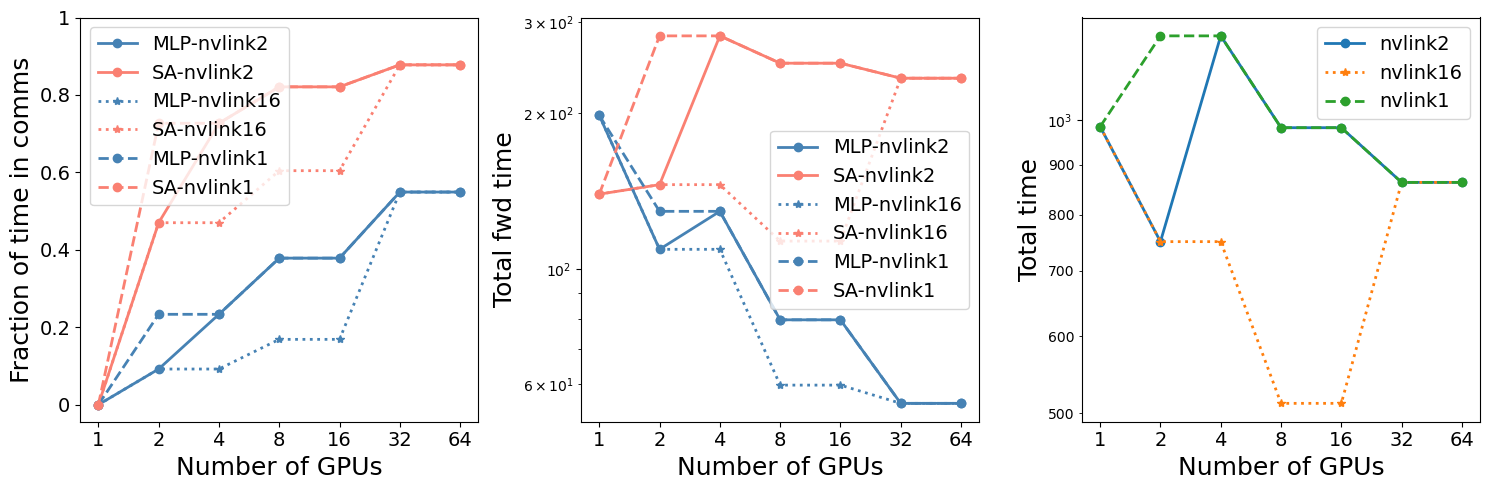

In [8]:
# Sweeps
### model parallelism
n_gpus = [1, 2, 4, 8, 16, 32, 64]
parallelism = {'m1': 1,
               'm2': 1}
topology = {'t1': 'ib',
            't2': 'nvlink'}
system = {'matrix_flops_fp16': 312,
          'vector_flops_fp32': 19.5,
          'vector_flops_fp16': 78,
          'hbm_bandwidth': 1555,
          'nvlink_bandwidth': 300,
          'ib_bandwidth': 100,
          'nvlink_size': 8}

fig, axs = plt.subplots(1,3,figsize=(15,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

nvs = 2
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot(n_gpus, parallelism, topology, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, parallelism, topology, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
system['nvlink_size'] = 1
lgnd += ["MLP-nvlink1", "SA-nvlink1"]
lgnd_tot += ["nvlink1"]
plot(n_gpus, parallelism, topology, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")